# Preamble

In [1]:
# reload modules
from importlib import reload

# load pretrained segmentation models (written in pytorch)
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# torchvision
from torchviz import make_dot
import torchvision.transforms.v2 as TF

# torchmetrics
from torchmetrics.classification import Dice, BinaryJaccardIndex

# Serialize/Deserialize Json files
import json

# Data Augmentation
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

# get data/time with desired format
from datetime import datetime

time_format = "%Y.%m.%d@%H-%M-%S"

# work with images
import cv2
from PIL import Image

# keep numpy use to a min
# as we store our torch.Tensors to GPU Vram but numpy in RAM (it only supports CPU)
import pandas as pd
import numpy as np
import random

# to have a progress bar
from tqdm import tqdm

# To use pretrained segmentation models (implement in PyTorch)

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
# uncomment if wan't to globally aloow sns to handle plot style
# it adds unwanted style (i.e., grid) to .imshow()
# so better to use it a context manager to style only what I want
# >>> with sns.axes_style('darkgrid'):
# >>>     plt.imshow(...)
# sns.set_theme(
#     context="notebook",
#     style="darkgrid",
#     palette="deep",
#     font="sans-serif",
#     font_scale=1,
#     color_codes=True,
#     rc={'axes.grid': False},
# )

# OS/File/Path management
import sys
import os

# load my custom Classes/Functions/etc.
from utils.dataset import SegmentaionDataset
from utils.models.unet import UnetScratch

/home/tekboart/.local/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/tekboart/.local/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have 

## Set up GPU use


In [2]:
print("PyTorch ver:", torch.__version__)

# set max_split_size_mb to avoid GPU VRAM (out of MEM error)
# Could use terminal/shell instead:
# for linux: export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
# for winows: set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

# force pytorch to use GPU
# use "model.to(device)" later on to force a model use Cuda GPU
print("Can I use GPU?", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device used for calculation (CPU\Cuda):", device)

PyTorch ver: 2.0.1+cu118
Can I use GPU? True
Device used for calculation (CPU\Cuda): cuda:0


## Set Hyperparameters


In [3]:
hyper_params = {
    "lr": 1e-3,
    "batch_size": 8,
    "num_classes": 1,
    "epochs": 50,
    "num_workers": 2,
    "image_height": 352,
    "image_width": 640,
    "input_channels": 3,
    "num_classes": 1,
    "pin_mem": True,
    "lr_decay_step": 5,
    "lr_decary_factor": 0.5,
    "pretrained_model_encoder": 'mobilenet_v2',
    "train_img_dir": os.path.join("data", "traincrop", "img"),
    "train_mask_dir": os.path.join("data", "traincrop", "mask"),
    "val_img_dir": os.path.join("data", "valcrop", "img"),
    "val_mask_dir": os.path.join("data", "valcrop", "mask"),
    "test_img_dir": os.path.join("data", "testcrop", "img"),
    "test_mask_dir": os.path.join("data", "testcrop", "mask"),
}

# if have used pretrained_model's 
IMAGENET_MEAN = [0.485, 0.456, 0.406] 
IMAGENET_STD = [0.229, 0.224, 0.225]  
# imagenet's mean as ndarray (chennels_first) (for broadcasting + plt.imshow())
IMAGENET_MEAN_NDARRAY = np.array(IMAGENET_STD).reshape((3, 1, 1))
# imagenet's std as ndarray (chennels_first) (for broadcasting + plt.imshow())
IMAGENET_STD_NDARRAY = np.array(IMAGENET_STD).reshape((3, 1, 1))


# ----- Remove sources of non-determinism ---
# -- Set Random Seed --
# use to seed the RNG for all devices (both CPU and CUDA).
torch.manual_seed(0)
# for custom operators, you might need to set python seed as well:
random.seed(0)
# If you or any of the libraries you are using rely on NumPy, you can seed the global NumPy RNG with:
np.random.seed(0)

# configure PyTorch to use deterministic algorithms instead of nondeterministic ones 
# A CAVEAT: throws an error if an operation is known to be nondeterministic (and without a deterministic alternative).
# that is why we used warn_only to avoid raising Error
torch.use_deterministic_algorithms(True, warn_only=True)
# CUDA convolution determinism
torch.backends.cudnn.deterministic = True

# -- DataLoader
# make it deterministic but allow it to random data order
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

DATA_LOADER_GEN = torch.Generator()
DATA_LOADER_GEN.manual_seed(0)

# Define Model(s)


## Import a Pretrained Segmentaion model (e.g., UNET)


In [4]:
# the downloaded model are located in "~/.cache/torch/hub/checkpoints/"
# the models I've downloaded: 
# 'mobilenet_v2' (works better with FPN than UNET)
# 'timm-mobilenetv3_large_100'
# 'resnet34'
# 'resnet152'
# 'timm-efficientnet-b8'

# define the architecture of our model
# smp models are just a subclass of PyTorch nn.Module
# e.g., Unet, UnetPlusPlus, FPN, DeepLabV3Plus
model_arch = smp.UnetPlusPlus

# create the model
model = model_arch(
    # choose encoder
    encoder_name=hyper_params['pretrained_model_encoder'],
    # use `imagenet` pre-trained weights for encoder initialization
    encoder_weights="imagenet",
    # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    in_channels=hyper_params['input_channels'],
    # model output channels (number of classes in your dataset)
    classes=hyper_params['num_classes'],
)

# load preprocessing func of the loaded model, so our data goes through the same transformation
# hint 1: it needs the input img to be in channels_last format
# hint 2: it outputs the image in channels_last format! (e.g., toch.Size[640, 360, 3])
# hint 3: gets ndarray and outputs ndarray
# hint 4: the values are z-scored by, for instance, ImageNet's variance and mean
# but the values are not [-1, 1] but a sandard normal distri (68.3% of pixel values are within [-1, 1])
preprocess_input = get_preprocessing_fn(
    hyper_params['pretrained_model_encoder'], pretrained='imagenet')


# Save the model's Name (e.g., UNet, FPN) as a str to hyperparams
hyper_params['pretrained_model_arch'] = str(model.__class__).split(".")[-1][:-2]

### Visualize the architecture


In [5]:
# plot the model arch
# create a dumy channels_first img (m, C, H, W)
# x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)
# must do a forward pass (to init weights so shapes are set)
# yhat = model(x)

# save the architecture of the model as an image
# make_dot(yhat, params=dict(list(model.named_parameters()))).render("./outputs/model_plot/Unet_pretrained", format="png")

In [6]:
# arch as simple text
print(model.__str__())

UnetPlusPlus(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel

## Load a Segmentation Model (i.e., UNET), written from scratch


In [7]:
# model = UnetScratch(in_channels=3, num_classes=hyper_params["num_classes"])

# Create Dataset


## Define Data Augmentations

In [8]:
#preprocess_input Define a set of augmentations (resize, rescale, augmentation, etc.)
train_transform = A.Compose(
    [
        A.Resize(height=hyper_params['image_height'],
                 width=hyper_params['image_width']),
        # A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        # A.RandomRotate90(p=1),  # Use only when the img_height==img_width
        # A.Transpose(p=1),  # Use only when the img_height==img_width
        A.RandomBrightnessContrast(p=0.8),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2,
                      hue=0.2, always_apply=False, p=0.8),
        # A.ImageCompression(quality_lower=99, quality_upper=100, p=0.5),
        A.RGBShift(r_shift_limit=10, g_shift_limit=10,
                   b_shift_limit=10, p=0.5),
        # normalizes the data to [0, 1]
        # A.Normalize(mean=[0.0, 0.0, 0, 0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
        # normalize the data by ImageNet's mean and std
        # A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, max_pixel_value=255.0),
        # ToTensorV2(),
    ],
    # is_check_shapes=False,  # risky
)

# we don't want TTA, just some resize, normalization, etc.
val_transform = A.Compose(
    [
        A.Resize(height=hyper_params['image_height'],
                 width=hyper_params['image_width']),
        # normalizes the data to [0, 1]
        # A.Normalize(mean=[0.0, 0.0, 0, 0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
        # normalize the data by ImageNet's mean and std
        # A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, max_pixel_value=255.0),
        # ToTensorV2(),
    ],
    # is_check_shapes=False,  # risky
)

## Create and load Datasets (as PyTorch loader)

In [9]:
from utils.dataset import get_loaders, SegmentaionDataset
import utils.dataset
reload(utils.dataset)

# create our datasets (with our custom Class)
train_ds = SegmentaionDataset(
    image_dir=hyper_params['train_img_dir'],
    mask_dir=hyper_params['train_mask_dir'],
    transform=train_transform,
    preprocess_fn=preprocess_input,
    mask_suffix="",
    # subset=[0, 10],
)
val_ds = SegmentaionDataset(
    image_dir=hyper_params['val_img_dir'],
    mask_dir=hyper_params['val_mask_dir'],
    transform=val_transform,
    preprocess_fn=preprocess_input,
    mask_suffix="",
    # subset=[0, 5],
)
test_ds = SegmentaionDataset(
    image_dir=hyper_params['test_img_dir'],
    mask_dir=hyper_params['test_mask_dir'],
    transform=val_transform,
    mask_suffix="",
    subset=[0, 5],
)

# Create Datatset by data loaders
train_loader, val_loader, test_loader = get_loaders(
    train_ds,
    val_ds,
    test_ds,
    hyper_params['batch_size'],
    hyper_params['num_workers'],
    hyper_params['pin_mem'],
    worker_init_fn=seed_worker,
    generator=DATA_LOADER_GEN,
)

In [10]:
# (Fast) Using Dataset's __len__ magic method (always work)
print("# train images:", len(train_ds))
print("# val images:", len(val_ds))
# print("# test images:", len(test_ds))

# (Slow) Using Data Loader (is a hit or miss)
# print('# train images:', sum(len(batch) for batch in train_loader))
# print('# val images:', sum(len(batch) for batch in val_loader))

# this outputs wrong nume (why??)
# it's not even the #imgs in mini_batch??
# print(len(train_loader))

# train images: 1896
# val images: 348


## Visualize Dataset(s)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img.min() = -0.17756862745098037
img.max() = 0.815078431372549
img.min() = -0.24815686274509804
img.max() = 0.819
img.min() = -0.256
img.max() = 0.819


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img.min() = -0.15403921568627452
img.max() = 0.7523333333333333


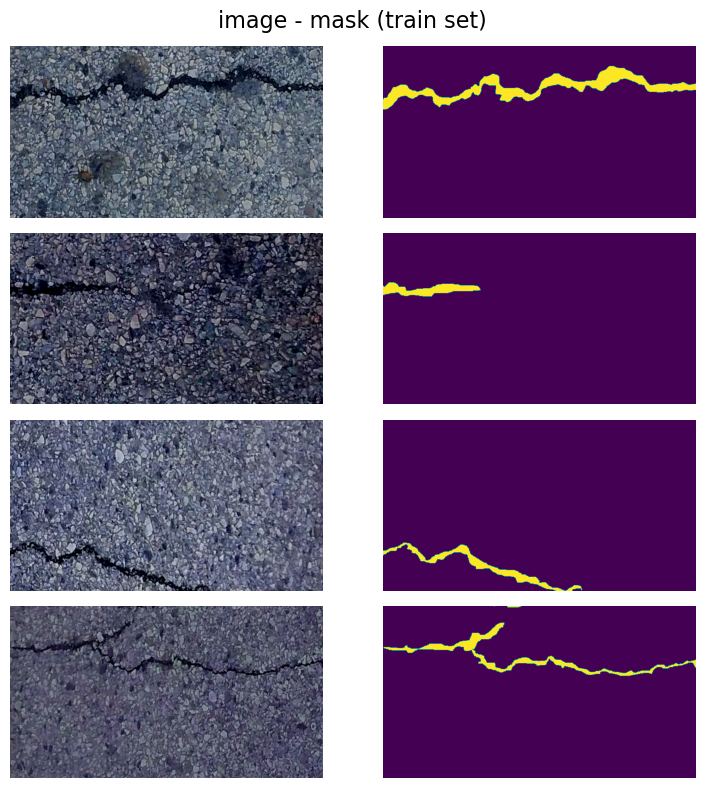

In [11]:
img_mask_iter = ((img, mask) for img, mask in train_ds)

plt.figure(figsize=(8, 8))
for i in range(0, 4 * 2, 2):
    img, mask = next(img_mask_iter)
    # if the img is z-scored (by ImageNet), then make it [0, 1]
    # doesn't quite work (maybe because of data augmentation)
    img = np.multiply(img, IMAGENET_STD_NDARRAY) + IMAGENET_MEAN_NDARRAY
    print(f'{img.min() = }')
    print(f'{img.max() = }')
    plt.subplot(4, 2, i + 1)
    plt.imshow(np.moveaxis(img, 0, -1))
    plt.axis("off")
    plt.subplot(4, 2, i + 2)
    plt.imshow(np.moveaxis(mask, 0, -1))
    plt.axis("off")

plt.suptitle("image - mask (train set)", fontsize=16)
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


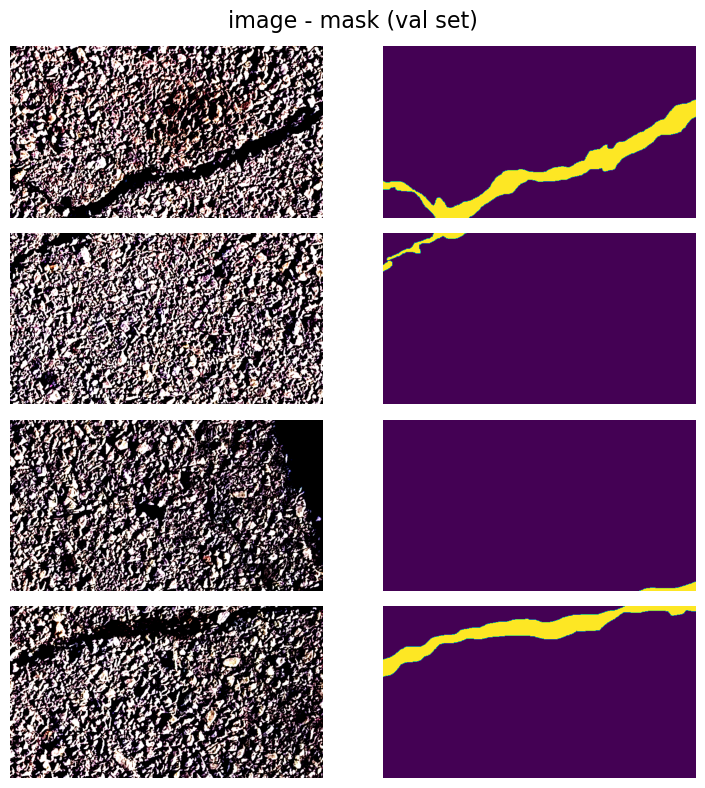

In [12]:
img_mask_iter = ((img, mask) for img, mask in val_ds)

plt.figure(figsize=(8, 8))
for i in range(0, 8, 2):
    img, mask = next(img_mask_iter)
    plt.subplot(4, 2, i + 1)
    plt.imshow(np.moveaxis(img, 0, -1))
    plt.axis("off")
    plt.subplot(4, 2, i + 2)
    plt.imshow(np.moveaxis(mask, 0, -1))
    plt.axis("off")

plt.suptitle("image - mask (val set)", fontsize=16)
plt.tight_layout()
plt.show()

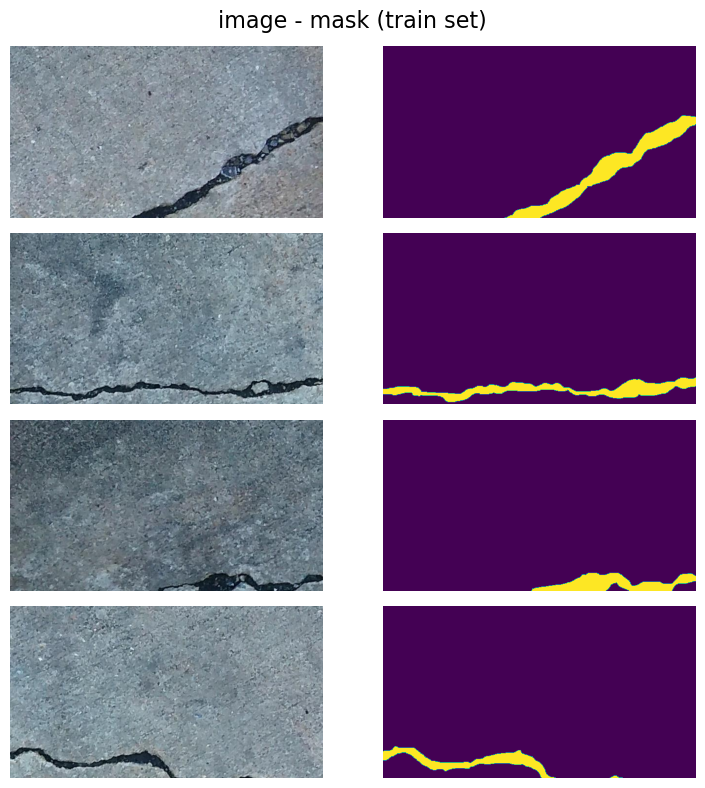

In [13]:
img_mask_iter = ((img, mask) for img, mask in test_ds)

plt.figure(figsize=(8, 8))
for i in range(0, 8, 2):
    img, mask = next(img_mask_iter)
    plt.subplot(4, 2, i + 1)
    plt.imshow(np.moveaxis(img, 0, -1))
    plt.axis("off")
    plt.subplot(4, 2, i + 2)
    plt.imshow(np.moveaxis(mask, 0, -1))
    plt.axis("off")

plt.suptitle("image - mask (train set)", fontsize=16)
plt.tight_layout()
plt.show()

# Train


In [14]:
from utils.metrics import (
    AccuracyBinarySegment,
    DiceBinarySegment,
    JaccardBinarySegment,
)

from utils.training import train_model
import utils.training
import utils.metrics

reload(utils.training)
reload(utils.metrics)


# a dict to map metrics' name to correspoing fn
metrics = {
    "accuracy": AccuracyBinarySegment(),  # remove as its very misleading
    "dice (F1 Score)": DiceBinarySegment(),  # my custom dice
    "jaccard (IOU)": JaccardBinarySegment(),  # my custom jaccard
    #TODO: Create funcs to calc TP, TN, FN, then use them to calc other metrics (e.g., Dice, Precision, Recall)
    #TODO: add Precision
    #TODO: add Recall
    # "dice_torch": Dice(average="micro").to(device),
    # "jaccard_torch": BinaryJaccardIndex().to(device),
}

# get the date-time (for filenames)
train_timestamp = datetime.today().strftime(time_format)

# define the loss_fn
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.BCELoss()
#TODO: Create DICE+BCE loss func (as most papers use this)

# define the optimizer
optimizer = optim.Adam(model.parameters(), lr=hyper_params["lr"])

# define the scheduler
scheduler = StepLR(
    optimizer,
    step_size=hyper_params["lr_decay_step"],
    gamma=hyper_params["lr_decary_factor"],
)

# train the model
history = train_model(
    model,
    train_loader,
    optimizer,
    loss_fn,
    scheduler,
    metrics=metrics,
    val_loader=val_loader,
    epochs=hyper_params["epochs"],
    device=device,
    save_model=True,
    save_model_filename=f"models{os.sep}{train_timestamp}@model_checkpoint",
    save_model_temp=True,
    save_model_temp_filename=f"temp{os.sep}epoch_best_model_checkpoint{os.sep}temp_model_checkpoint",
)

# save hyperparams as a JSON file
hyper_params_export_name = f"outputs{os.sep}hyperparams{os.sep}{train_timestamp}@hyperparams.json"
with open(hyper_params_export_name, "w") as f:
    json.dump(hyper_params, f)

# save the hyperparams to a csv file
# df_hyperparam = pd.DataFrame(hyper_params, index=[0]).T
# df_hyperparam.to_csv(f'outputs/hyperparams/{start_train_time}@hyperparams.csv', index=True, header=None)
# print('The HyperParameters'.ljust(79, " "))
# display(df_hyperparam)
# del df_hyperparam

---------------------------------- epoch 1/50 ---------------------------------


Epoch 1: 100%|██████████| 237/237 [00:17<00:00, 13.79it/s]



loss:                0.122335  
jaccard:             0.48      
dice:                0.64      
accuracy:            0.96      
val_loss:            0.071438  
val_jaccard:         0.55      
val_dice:            0.69      
val_accuracy:        0.97      
---------------------------------- epoch 2/50 ---------------------------------


Epoch 2: 100%|██████████| 237/237 [00:15<00:00, 15.04it/s]



loss:                0.089044  
jaccard:             0.56      
dice:                0.71      
accuracy:            0.97      
val_loss:            0.064837  
val_jaccard:         0.60      
val_dice:            0.73      
val_accuracy:        0.97      
---------------------------------- epoch 3/50 ---------------------------------


Epoch 3: 100%|██████████| 237/237 [00:16<00:00, 14.73it/s]



loss:                0.082764  
jaccard:             0.59      
dice:                0.74      
accuracy:            0.97      
val_loss:            0.086851  
val_jaccard:         0.55      
val_dice:            0.70      
val_accuracy:        0.97      
---------------------------------- epoch 4/50 ---------------------------------


Epoch 4: 100%|██████████| 237/237 [00:15<00:00, 14.96it/s]



loss:                0.081730  
jaccard:             0.59      
dice:                0.74      
accuracy:            0.97      
val_loss:            0.060065  
val_jaccard:         0.60      
val_dice:            0.74      
val_accuracy:        0.98      
---------------------------------- epoch 5/50 ---------------------------------


Epoch 5: 100%|██████████| 237/237 [00:15<00:00, 15.20it/s]



loss:                0.080768  
jaccard:             0.60      
dice:                0.75      
accuracy:            0.97      
val_loss:            0.059164  
val_jaccard:         0.63      
val_dice:            0.76      
val_accuracy:        0.98      
---------------------------------- epoch 6/50 ---------------------------------


Epoch 6: 100%|██████████| 237/237 [00:15<00:00, 15.10it/s]



loss:                0.074569  
jaccard:             0.62      
dice:                0.76      
accuracy:            0.97      
val_loss:            0.056554  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
---------------------------------- epoch 7/50 ---------------------------------


Epoch 7: 100%|██████████| 237/237 [00:15<00:00, 14.98it/s]



loss:                0.072421  
jaccard:             0.63      
dice:                0.77      
accuracy:            0.97      
val_loss:            0.057668  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
---------------------------------- epoch 8/50 ---------------------------------


Epoch 8: 100%|██████████| 237/237 [00:15<00:00, 14.87it/s]



loss:                0.071779  
jaccard:             0.63      
dice:                0.77      
accuracy:            0.97      
val_loss:            0.060131  
val_jaccard:         0.62      
val_dice:            0.75      
val_accuracy:        0.98      
---------------------------------- epoch 9/50 ---------------------------------


Epoch 9: 100%|██████████| 237/237 [00:16<00:00, 14.66it/s]



loss:                0.070198  
jaccard:             0.63      
dice:                0.77      
accuracy:            0.97      
val_loss:            0.054691  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 10/50 ---------------------------------


Epoch 10: 100%|██████████| 237/237 [00:15<00:00, 15.07it/s]



loss:                0.069426  
jaccard:             0.64      
dice:                0.78      
accuracy:            0.97      
val_loss:            0.059209  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 11/50 ---------------------------------


Epoch 11: 100%|██████████| 237/237 [00:15<00:00, 14.84it/s]



loss:                0.065992  
jaccard:             0.65      
dice:                0.79      
accuracy:            0.97      
val_loss:            0.054776  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 12/50 ---------------------------------


Epoch 12: 100%|██████████| 237/237 [00:16<00:00, 14.75it/s]



loss:                0.065459  
jaccard:             0.65      
dice:                0.79      
accuracy:            0.97      
val_loss:            0.060866  
val_jaccard:         0.62      
val_dice:            0.75      
val_accuracy:        0.98      
--------------------------------- epoch 13/50 ---------------------------------


Epoch 13: 100%|██████████| 237/237 [00:15<00:00, 14.93it/s]



loss:                0.064072  
jaccard:             0.66      
dice:                0.79      
accuracy:            0.98      
val_loss:            0.055784  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 14/50 ---------------------------------


Epoch 14: 100%|██████████| 237/237 [00:15<00:00, 14.89it/s]



loss:                0.062828  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.054355  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 15/50 ---------------------------------


Epoch 15: 100%|██████████| 237/237 [00:15<00:00, 15.15it/s]



loss:                0.061921  
jaccard:             0.66      
dice:                0.79      
accuracy:            0.98      
val_loss:            0.054928  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 16/50 ---------------------------------


Epoch 16: 100%|██████████| 237/237 [00:15<00:00, 15.05it/s]



loss:                0.060599  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.053756  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 17/50 ---------------------------------


Epoch 17: 100%|██████████| 237/237 [00:15<00:00, 15.12it/s]



loss:                0.059574  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.053443  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 18/50 ---------------------------------


Epoch 18: 100%|██████████| 237/237 [00:15<00:00, 15.17it/s]



loss:                0.059367  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.054810  
val_jaccard:         0.66      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 19/50 ---------------------------------


Epoch 19: 100%|██████████| 237/237 [00:15<00:00, 14.91it/s]



loss:                0.058303  
jaccard:             0.68      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.053164  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 20/50 ---------------------------------


Epoch 20: 100%|██████████| 237/237 [00:15<00:00, 15.17it/s]



loss:                0.058232  
jaccard:             0.68      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.055850  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 21/50 ---------------------------------


Epoch 21: 100%|██████████| 237/237 [00:15<00:00, 14.97it/s]



loss:                0.056144  
jaccard:             0.68      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.054178  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 22/50 ---------------------------------


Epoch 22: 100%|██████████| 237/237 [00:15<00:00, 15.12it/s]



loss:                0.056607  
jaccard:             0.68      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.054324  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 23/50 ---------------------------------


Epoch 23: 100%|██████████| 237/237 [00:15<00:00, 14.97it/s]



loss:                0.056007  
jaccard:             0.68      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.055200  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 24/50 ---------------------------------


Epoch 24: 100%|██████████| 237/237 [00:16<00:00, 14.74it/s]



loss:                0.054981  
jaccard:             0.68      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.055236  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 25/50 ---------------------------------


Epoch 25: 100%|██████████| 237/237 [00:16<00:00, 14.46it/s]



loss:                0.055213  
jaccard:             0.69      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.055107  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 26/50 ---------------------------------


Epoch 26: 100%|██████████| 237/237 [00:15<00:00, 14.98it/s]



loss:                0.054492  
jaccard:             0.69      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.054578  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 27/50 ---------------------------------


Epoch 27: 100%|██████████| 237/237 [00:16<00:00, 14.79it/s]



loss:                0.054684  
jaccard:             0.69      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.055037  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 28/50 ---------------------------------


Epoch 28: 100%|██████████| 237/237 [00:15<00:00, 15.01it/s]



loss:                0.054620  
jaccard:             0.69      
dice:                0.82      
accuracy:            0.98      
val_loss:            0.055149  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 29/50 ---------------------------------


Epoch 29: 100%|██████████| 237/237 [00:15<00:00, 14.92it/s]



loss:                0.053982  
jaccard:             0.69      
dice:                0.82      
accuracy:            0.98      
val_loss:            0.054736  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 30/50 ---------------------------------


Epoch 30: 100%|██████████| 237/237 [00:16<00:00, 14.72it/s]



loss:                0.054364  
jaccard:             0.69      
dice:                0.82      
accuracy:            0.98      
val_loss:            0.055077  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 31/50 ---------------------------------


Epoch 31: 100%|██████████| 237/237 [00:15<00:00, 14.84it/s]



loss:                0.053610  
jaccard:             0.69      
dice:                0.82      
accuracy:            0.98      
val_loss:            0.055235  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 32/50 ---------------------------------


Epoch 32: 100%|██████████| 237/237 [00:16<00:00, 14.79it/s]



loss:                0.052919  
jaccard:             0.70      
dice:                0.82      
accuracy:            0.98      
val_loss:            0.054969  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 33/50 ---------------------------------


Epoch 33: 100%|██████████| 237/237 [00:15<00:00, 14.81it/s]



loss:                0.053430  
jaccard:             0.69      
dice:                0.82      
accuracy:            0.98      
val_loss:            0.055053  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 34/50 ---------------------------------


Epoch 34: 100%|██████████| 237/237 [00:15<00:00, 14.92it/s]



loss:                0.053295  
jaccard:             0.69      
dice:                0.82      
accuracy:            0.98      
val_loss:            0.055137  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 35/50 ---------------------------------


Epoch 35: 100%|██████████| 237/237 [00:17<00:00, 13.42it/s]



loss:                0.053059  
jaccard:             0.70      
dice:                0.82      
accuracy:            0.98      
val_loss:            0.054487  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 36/50 ---------------------------------


Epoch 36: 100%|██████████| 237/237 [00:17<00:00, 13.83it/s]



loss:                0.053182  
jaccard:             0.70      
dice:                0.82      
accuracy:            0.98      
val_loss:            0.054322  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 37/50 ---------------------------------


Epoch 37: 100%|██████████| 237/237 [00:15<00:00, 14.81it/s]



loss:                0.052668  
jaccard:             0.70      
dice:                0.82      
accuracy:            0.98      
val_loss:            0.055157  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 38/50 ---------------------------------


Epoch 38: 100%|██████████| 237/237 [00:16<00:00, 14.50it/s]



loss:                0.053461  
jaccard:             0.69      
dice:                0.82      
accuracy:            0.98      
val_loss:            0.055015  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 39/50 ---------------------------------


Epoch 39: 100%|██████████| 237/237 [00:15<00:00, 14.92it/s]



loss:                0.052629  
jaccard:             0.70      
dice:                0.82      
accuracy:            0.98      
val_loss:            0.055225  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 40/50 ---------------------------------


Epoch 40: 100%|██████████| 237/237 [00:15<00:00, 14.96it/s]



loss:                0.052663  
jaccard:             0.70      
dice:                0.82      
accuracy:            0.98      
val_loss:            0.055731  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 41/50 ---------------------------------


Epoch 41: 100%|██████████| 237/237 [00:16<00:00, 14.74it/s]


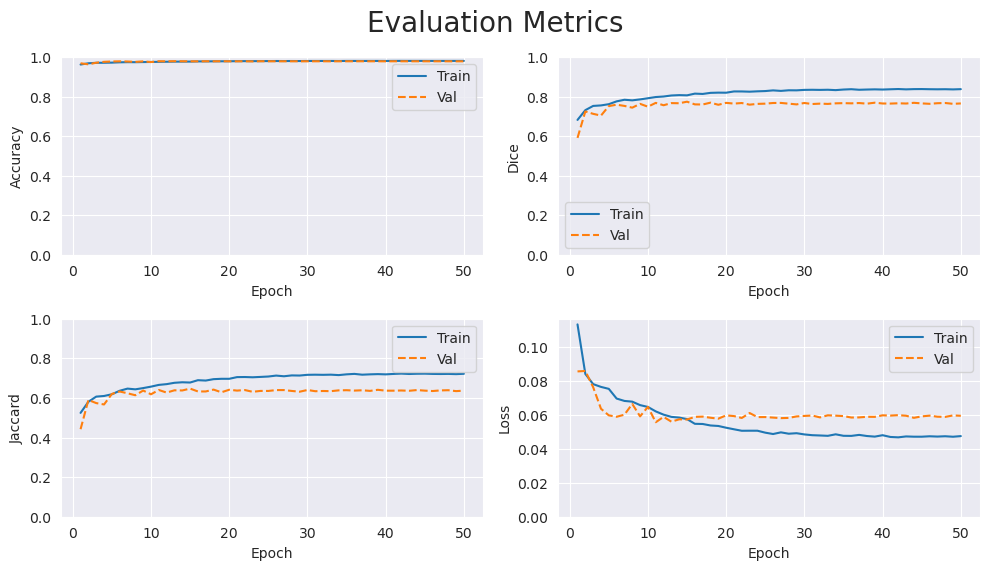

In [ ]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]


def plot_metrics(
    history: dict, epochs: int, metrics: list = ["loss"], auc_min: float = 0.8
) -> None:
    """
    Plot the metrics (for both the train and val)

    Parameters
    ----------
    history: dict
        the output of model.fit()
    epochs: int
        the #epochs we trained the model
    metrics: list
        a list of metrics to be plotted
    auc_min: 0.8
        as we need to zoom-in more for AUC curve, we use this to limit the range

    returns
    -------
    None
    """
    plt.figure(figsize=(10, 8))
    # take the ceiling of #metrics provided as the #rows
    plot_height = int(len(metrics) / 2) + 1

    for i, metric in enumerate(metrics):
        name = metric.replace("_", " ").title()
        plt.subplot(plot_height, 2, i + 1)
        plt.plot(range(1, epochs + 1),
                 history[metric], color=colors[0], label="Train")
        plt.plot(
            range(1, epochs + 1),
            history["val_" + metric],
            color=colors[1],
            linestyle="--",
            label="Val",
        )
        plt.xlabel("Epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "auc":
            plt.ylim([auc_min, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()
        plt.tight_layout()


# allow seaborn to set the style only for this plot
with sns.axes_style("darkgrid", rc={"axes.grid": True}):
    plot_metrics(history, hyper_params["epochs"], list(metrics) + ["loss",])
    plt.suptitle("Evaluation Metrics", fontsize=20)
    plt.tight_layout()
    plt.savefig(
        f"outputs/plots/{train_timestamp}@train_val_metric_plots.pdf", bbox_inches="tight")
    plt.show()

In [ ]:
df = pd.DataFrame(history)
df.insert(loc=0, column="epoch", value=range(1, len(df.index) + 1))
df.to_csv(f"outputs/history/{train_timestamp}@train_val_metric_values.csv", index=False)
display(df)
del df

,epoch,loss,accuracy,dice,jaccard,val_loss,val_accuracy,val_dice,val_jaccard
0,1,0.113593,0.961765,0.682093,0.524414,0.085824,0.968108,0.591342,0.442066
1,2,0.084335,0.968243,0.731409,0.580552,0.086081,0.962919,0.724713,0.589730
2,3,0.078317,0.970537,0.752782,0.606650,0.076506,0.970892,0.712852,0.573953
3,4,0.076679,0.970827,0.755330,0.609840,0.063770,0.975552,0.703958,0.566952
4,5,0.075518,0.971460,0.761554,0.618512,0.059866,0.977242,0.751863,0.620105
5,6,0.069789,0.973055,0.775891,0.636243,0.059029,0.978038,0.759078,0.632530
6,7,0.068385,0.973819,0.783919,0.647074,0.060271,0.977141,0.752777,0.623508
7,8,0.067957,0.973669,0.780948,0.643427,0.066619,0.975233,0.744064,0.613619
8,9,0.065913,0.974293,0.785755,0.649730,0.059267,0.977891,0.763208,0.637272
9,10,0.064836,0.974800,0.791594,0.657008,0.064884,0.974352,0.748890,0.618394


# Test (MOVE THIS TO ANOTHER NOTEBOOK AND USE THE SAVED CHECKPOINT MODEL)


In [ ]:
# use the model on test set

In [ ]:
def evaluate_model(model, dataset, metrics) -> dict:
    # calc the yhat
    yhat = train_model(model.cpu(), dataset, from_logits=True)

    # calc metrics
    metrics = 0

    # convert metrics to a dict (e.g., {'accuracy': int, 'dice': int, etc.})

    return metrics


# why evaluate train set?
a = pd.Series(evaluate_model(model, train_loader,
              ['loss',]+list(metrics)), name='Train')
# why evaluate the val set?
b = pd.Series(evaluate_model(model, val_loader, ['loss',]+list(metrics)), name='Val')
c = pd.Series(evaluate_model(model, test_loader,
              ['loss',]+list(metrics)), name='Test')

df = pd.concat([a, b, c], axis=1)
print('Model evaluation on diff sets')
display(df)
del df

# Inference (MOVE THIS TO ANOTHER NOTEBOOK AND USE THE SAVED CHECKPOINT MODEL)

> for single images


In [ ]:
# Load the model checkpoint

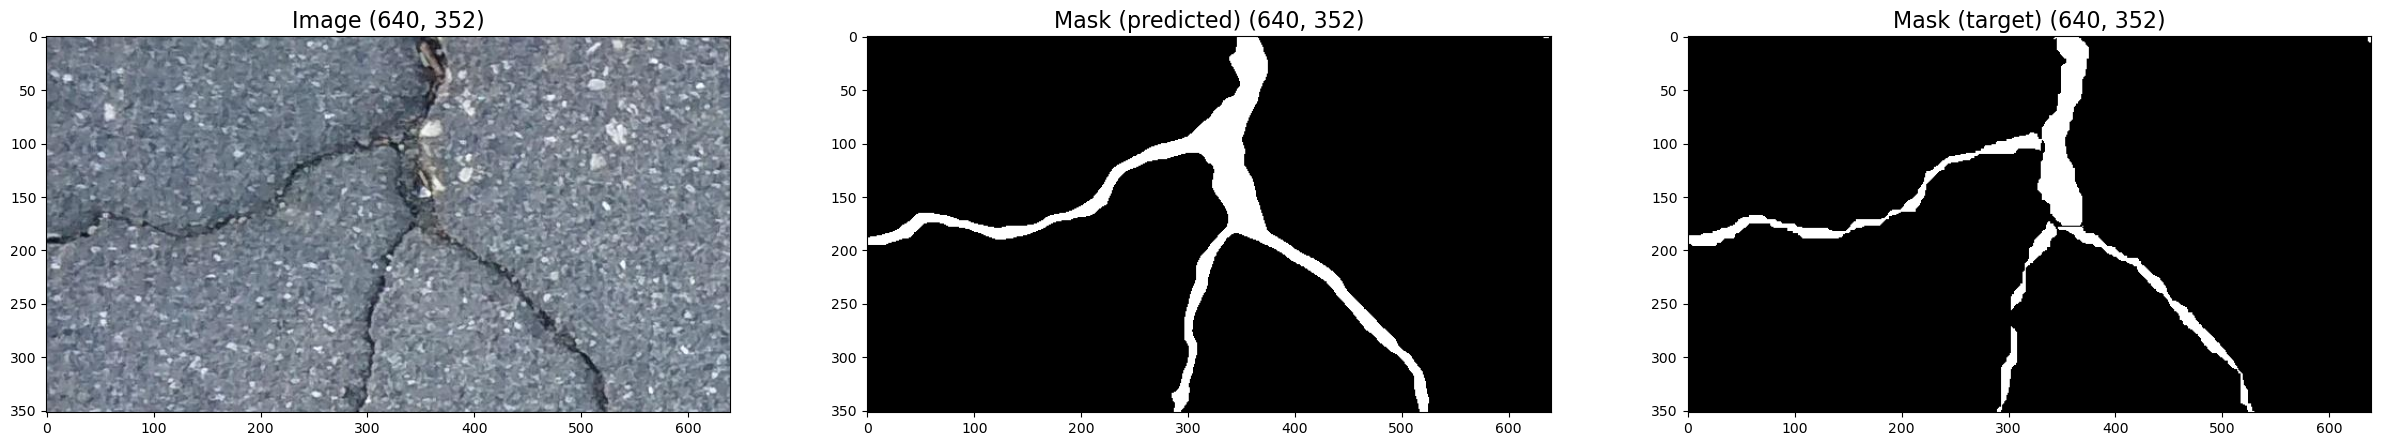

In [ ]:
# Lowres images
# img 1 (from traincrop)
# img_filename =  '20160222_081011_1_721.jpg'
# mask_filename = '20160222_081011_1_721_mask.png'
# img 2 (from testcrop)
img_filename = '20160307_164226_1_1.jpg'
mask_filename = '20160307_164226_1_1_mask.png'
# Highres images (from train)
# img_filename =  '20160222_081102.jpg'
# mask_filename = '20160222_081102_mask.png'
img_addr = os.path.join('images', img_filename)
mask_addr = os.path.join('images', mask_filename)

img = Image.open(img_addr).resize((hyper_params['image_width'], hyper_params['image_height']))
mask = Image.open(mask_addr).resize((hyper_params['image_width'], hyper_params['image_height']))

# normalize [-1, 1] the PIL image as a torch.Tensor
img_tensor = (TF.functional.pil_to_tensor(img) / 127.5 - 1).to(device)

model.to(device)
yhat = model(img_tensor.unsqueeze(dim=0))
yhat_c_last = yhat[0].moveaxis(0, -1).detach().cpu().numpy()
thresh = 0.5
mask_batch = np.where(yhat_c_last >= thresh, 255, 0)

fig, axes = plt.subplots(1, 3, figsize=(30, 10))
axes[0].imshow(img)
axes[0].set_title(f'Image {img.size}', fontsize=16)
axes[1].imshow(mask_batch, cmap='gray')
axes[1].set_title(
    f'Mask (predicted) {mask_batch.shape[:2][::-1]}', fontsize=16)
axes[2].imshow(mask, cmap='gray')
axes[2].set_title(f'Mask (target) {mask.size}', fontsize=16)
plt.savefig(f'outputs/Inferences/{train_timestamp}@{img_filename}.png', bbox_inches='tight')
plt.show()

In [ ]:
from utils.visualization import torch_tensor_for_plt, plot_segmentation_inference
from utils.inferencing import inference_segmentation, img_to_inference_tensor
import utils.inferencing
import utils.visualization
reload(utils.inferencing)
reload(utils.visualization)


img_filename = '20160222_081011_1_721.jpg'
mask_filename = '20160222_081011_1_721_mask.jpg'
img_addr = os.path.join('images', img_filename)
mask_addr = os.path.join('images', mask_filename)

# only for one image, if multiple use utils.dataset
test_img_batch = img_to_inference_tensor(
    img_addr, size=(hyper_params['image_height'], hyper_params['image_width']))
test_mask_batch = img_to_inference_tensor(
    mask_addr, size=(hyper_params['image_height'], hyper_params['image_width']))

# make an inference
yhat_mask = inference_segmentation(
    test_img_batch, model=model, normalize=True, device=device)

# make torch.Tensors ready for pyplot
test_img_batch = torch_tensor_for_plt(test_img_batch)
test_mask_batch = torch_tensor_for_plt(test_mask_batch)
yhat_mask = torch_tensor_for_plt(yhat_mask)

# plot the inference
plot_segmentation_inference(test_img_batch, test_mask_batch, yhat_mask)

#
